# Main data analysis

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import geopandas as geop

Toca:
1. Ver que tanta gente hay en los hospitales importantes
2. Ver que tan lejos estan de las estaciones de trasmi
3. Con los datos de movilidad de bici, determinar una distancia maxima a la que la gente podria moverse

Luego dos partes:
1. Que porcentaje de la gente que esta alrededor del hospital puede lograrla solo en bici. Calcular cuantas para poner bicis en el hospital, o darle bicis a esas personas.
2. Que porcentage le toca en trasmi. Aca es mas dificil porque falta la parte de saber de donde van a venir para organizar las rutas

In [218]:
# read data
# ips_geo
ips_geo_important =pd.read_parquet('../data/02_processed/ips_geo_important.parquet')
# capacities_per_nit
capacities_per_nit = pd.read_parquet('../data/02_processed/capacities_per_nit.parquet')
# estaciones
estaciones= pd.read_parquet('../data/02_processed/estaciones.parquet')

In [219]:
# add capacities to ips
ips_geo_cap = pd.merge(
    ips_geo_important,
    capacities_per_nit,
    on='nit_ips',
    how='inner'
)

In [220]:
#ips_geo_cap.to_csv('../data/02_processed/ips_geo_cap.csv')

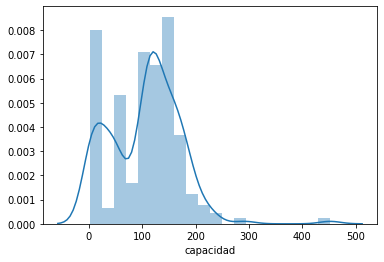

In [221]:
sns.distplot(ips_geo_cap.capacidad, bins=20)

## Asignacion de personal a cada ips

load here file with cap and estimated workers (this step was done manually, details in documentation)

In [229]:
ips_empleados = pd.read_csv('../data/02_processed/ips_geo_capacidad_empleados.csv', sep=';')
ips_empleados.columns = ['nombre_ips', 'capacidad', 'empleados']

In [231]:
ips_empleados.empleados.sum()

107100

## De donde viene la gente a las ips? (region de la ips)

In [168]:
# load utam data
utam = pd.read_pickle('../data/02_processed/utam.pkl')
utam_basic = utam[['utam', 'hogares', 'geometry', 'centroide']]

In [169]:
# load viajes_vol
viajes_vol = pd.read_parquet('../data/02_processed/viajes_vol.parquet')
viajes_vol.columns

Index(['utam_origen', 'utam_destino', 'viajeros'], dtype='object')

In [177]:
ips_geo_utam = geop.sjoin(
    geop.GeoDataFrame(ips_geo_cap,
                      geometry=geop.points_from_xy(ips_geo_cap.longitud_ips, ips_geo_cap.latitud_ips)),
    utam_basic,
    how='inner',
    op='intersects'
).drop(columns='index_right', axis=1).rename(columns={'utam':'utam_ips','hogares':'hogares_ips', 'centroide':'centroide_ips'})

ips_geo_utam.columns

C:\Users\User\Anaconda3\envs\movilidad\lib\site-packages\geopandas\tools\sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4686'})
  warn(


Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad',
       'geometry', 'utam_ips', 'hogares_ips', 'centroide_ips'],
      dtype='object')

In [178]:
ips_geo_utam.shape

(397, 13)

Unimos la informacion de viajes

In [179]:
ips_geo_utam = pd.merge(
    ips_geo_utam,
    viajes_vol,
    left_on='utam_ips',
    right_on='utam_destino',
    how='left'
).drop('utam_destino', axis=1)

In [180]:
# merge utam destination information
ips_geo_utam = pd.merge(ips_geo_utam, utam_basic[['utam', 'geometry']], left_on='utam_origen', right_on='utam', suffixes=('_ips', '_origen'))

In [193]:
ips_geo_utam = ips_geo_utam.assign(distancia=lambda x: (1/1000)*geop.GeoSeries(x.geometry_ips,crs={'init':'epsg:4326'}).to_crs(epsg=3310).distance(geop.GeoSeries(x.geometry_origen,crs={'init':'epsg:4326'}).to_crs(epsg=3310)))

In [195]:
ips_geo_utam.head()

,direccion,clase_de_prestador,nit_ips,codigo_de_habilitacion,id_ips,nombre_ips,longitud_ips,latitud_ips,capacidad,geometry_ips,utam_ips,hogares_ips,centroide_ips,utam_origen,viajeros,utam,geometry_origen,distancia
0,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,61.0,POINT (-74.06984 4.62125),UTAM91,2421.0,POINT (-74.06594 4.61988),UTAM1,54.992841,UTAM1,"POLYGON ((-74.02609 4.82311, -74.02571 4.82311...",15.067569
1,KR 7 32 - 12 LOCAL 304,Instituciones - IPS,800149384,110010918623,748,ODONTOSANITAS SAN MARTIN,-74.067710,4.618809,179.0,POINT (-74.06771 4.61881),UTAM91,2421.0,POINT (-74.06594 4.61988),UTAM1,54.992841,UTAM1,"POLYGON ((-74.02609 4.82311, -74.02571 4.82311...",15.245021
2,KR 13 # 27 47,Instituciones - IPS,860007336,110010817121,957,CONSULTORIO DE EMPRESA AV VILLAS Y BANCO DE OC...,-74.071014,4.614649,48.0,POINT (-74.07101 4.61465),UTAM91,2421.0,POINT (-74.06594 4.61988),UTAM1,54.992841,UTAM1,"POLYGON ((-74.02609 4.82311, -74.02571 4.82311...",15.730913
3,CL 36 # 7 47 PI 3,Instituciones - IPS,860007336,110010817122,958,CONSULTORIO DE EMPRESA BANCO DE BOGOTA,-74.067370,4.623381,48.0,POINT (-74.06737 4.62338),UTAM91,2421.0,POINT (-74.06594 4.61988),UTAM1,54.992841,UTAM1,"POLYGON ((-74.02609 4.82311, -74.02571 4.82311...",14.797439
4,KR 13 A 35 38 Piso 5 Edificio torre B-35,Instituciones - IPS,860007336,110010817147,2128,CONSULTORIO DE EMPRESA BANCO DE BOGOTA 2,-74.068254,4.623526,48.0,POINT (-74.06825 4.62353),UTAM91,2421.0,POINT (-74.06594 4.61988),UTAM1,54.992841,UTAM1,"POLYGON ((-74.02609 4.82311, -74.02571 4.82311...",14.806583


In [197]:
ips_geo_utam.columns

Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad',
       'geometry_ips', 'utam_ips', 'hogares_ips', 'centroide_ips',
       'utam_origen', 'viajeros', 'utam', 'geometry_origen', 'distancia'],
      dtype='object')

Con estos datos necesitamos saber por cada ips
1. Que tan lejos estan los viajeros
2. Que proporcion es bike_eligible: a mas de 1km (caminar es mas practico) ya menos de 7 millas(mas que esto y la bicicleta tiene commute times muy largos)

In [256]:
bike_eligibility = (ips_geo_utam.
     assign(likely_mode=lambda x: np.select([x.distancia < 1,  x.distancia.between(1,7.5), x.distancia > 7.5],
                                           ['pie', 'bicicleta', 'publico'])).
     groupby(['id_ips','likely_mode']).agg({'viajeros': 'sum'}).
     assign(proporcion=lambda x: x.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))).
     reset_index()
)

In [257]:
bike_eligibility.to_parquet('../data/01_raw/bike_eligibility.parquet')
bike_eligibility

,id_ips,likely_mode,viajeros,proporcion
0,4,bicicleta,25696.413714,36.285346
1,4,pie,8973.251406,12.670933
2,4,publico,36147.941310,51.043721
3,5,bicicleta,40771.673266,54.815059
4,5,pie,24730.905965,33.249214
...,...,...,...,...
1186,2969,pie,77588.931541,52.636872
1187,2969,publico,43043.217726,29.200819
1188,2974,bicicleta,22614.601217,39.014127
1189,2974,pie,23387.999044,40.348373


Cuanto del share de viajeros esperamos que sea bike_eligible?

In [260]:
bike_eligibility.groupby('likely_mode').agg({'proporcion': ['mean', 'median']})

proporcion           
                  mean     median
likely_mode                      
bicicleta    39.232327  41.327260
pie          31.559550  29.147669
publico      29.208122  28.343810

~40% de los viajes de trabajo(frecuentes) deberian ocurrir a mas de 1km y a menos de 7.5 km de las ips, y deberia ser posible realizarlos en bicicleta

## Cuantas bicicletas serian necesarias?
En una primera aproximacion, podemos usar el numero estimado de personal multiplicado por el share de bike_eligibility. Despues, al refinar este esquema, podemos pensar en una rotacion de bicicletas por turnos. Lo cual podria reducir el nuemro de biucicletas por ips a la mitad o a un tercio (dos y tres turnos)

In [245]:
ips_geo_cap.columns

Index(['direccion', 'clase_de_prestador', 'nit_ips', 'codigo_de_habilitacion',
       'id_ips', 'nombre_ips', 'longitud_ips', 'latitud_ips', 'capacidad'],
      dtype='object')

In [263]:
ips_geo_bikes = (
    ips_geo_cap.
    merge(ips_empleados[['nombre_ips', 'empleados']],
          on='nombre_ips').
    merge(bike_eligibility.loc[lambda x:x.likely_mode=='bicicleta'][['id_ips', 'proporcion']],
          on='id_ips').
    assign(expected_bikes = lambda x: np.round(x.empleados*x.proporcion/100))
)

ips_geo_bikes.head()

,direccion,clase_de_prestador,nit_ips,codigo_de_habilitacion,id_ips,nombre_ips,longitud_ips,latitud_ips,capacidad,empleados,proporcion,expected_bikes
0,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,61.0,200,36.285346,73.0
1,AC 13 N 65 -21,Instituciones - IPS,800149384,110010918632,9,CLINISANITAS DIAGNOSTICO ZONA IN,-74.116059,4.634265,179.0,400,50.456112,202.0
2,AC 145 No. 88-76,Instituciones - IPS,800149384,110010918603,630,CLINISANITAS SUBA,-74.083538,4.737664,179.0,400,40.844726,163.0
3,TRV 59 A 114 - 18 PISO 3,Instituciones - IPS,800149384,110010918614,637,LABORATORIO CLINICO SANITAS SALUD OCUPACIONAL,-74.068402,4.696660,179.0,400,55.551195,222.0
4,KR 7 32 - 12 LOCAL 304,Instituciones - IPS,800149384,110010918623,748,ODONTOSANITAS SAN MARTIN,-74.067710,4.618809,179.0,400,36.285346,145.0


In [265]:
# guardamos estos datos en resultados
ips_geo_bikes.to_csv('../data/03_results/ips_bikes.csv')

Este resultado nos da el estimado de bicicletas necesarias por cada ips. En total tendriamos

In [264]:
ips_geo_bikes.expected_bikes.sum()

42293.0

Esta cifra es alcanzable teniendo en cuenta la disponibilidad de bibicletas del distrito y que es posible lanzar una campanha donde las personas presten su bicicleta durante la crisis. Yas que bogota cuenta con alrededor de 800k bicicletas. Una de cada 20 usuarias de bicicleta necesitarian prestar su bicicleta.

## Priorizacion de asignacion de bicicletas
Podemos proponer una priorizacin de asignacion de bicicletas teniendo en cuenta los siguientes factores:

1. IPS mas grandes deberian tener mayor prioridad, tenemos la estimacion de camas
2. IPS en zonas mas densas deberian tener mayor prioridad, pues van a tender a recibir mas casos mas rapido. Podemos estimar esto con los datos de numero de hogares en datos de utam 
3. IPS mas cerca a transporte publico deberia tener menor prioridad. Tratamos esto a continuacion

## Que tan lejos se encuentran estaciones de transmilenio de los hospitales principales
PAra aproximadamente 30% de los empleados la solucion de bicicletas no es viable. Al mismo tiempo, podria haber una dificultad en obtener el numero necesario de bicicletas

In [49]:
# merge ips and estaciones data
ips_estaciones = pd.merge(
    ips_geo_cap.assign(key=1),
    estaciones.assign(key=1),
    on = 'key'
).drop('key', axis=1)

In [50]:
ips_estaciones.shape

(59600, 21)

In [51]:
ips_estaciones.head()

,direccion,clase_de_prestador,nit_ips,codigo_de_habilitacion,id_ips,nombre_ips,longitud_ips,latitud_ips,capacidad,numero_estacion,...,ubicacion_estacion,troncal_estacion,numero_vagones_estacion,numero_accesos_estacion,biciestacion_estacion,capacidad_biciestacion_estacion,tipo_estacion,biciparqueadero_estacion,latitud_estacion,longitud_estacion
0,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,61.0,4003,...,Carrera 86,Calle 80,1,1,0,0,INTERMEDIA,NO,4.702500,-74.100253
1,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,61.0,7004,...,AutoSur-Av 54,NQS,2,1,0,0,SENCILLA,NO,4.595713,-74.141590
2,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,61.0,4105,...,Carrera 53,Calle 80,1,1,0,0,SENCILLA,NO,4.681940,-74.077365
3,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,61.0,7104,...,Kr 30 CL 63,NQS,2,1,0,0,SENCILLA,NO,4.657063,-74.077754
4,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,61.0,4000,...,Carrera 96,Calle 80,0,0,1,353,CABECERA,SI,4.709523,-74.110525


In [52]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [55]:
# agregar distancia
ips_estaciones = (ips_estaciones.
    assign(distancia=lambda x: haversine(x.latitud_ips, x.longitud_ips,
                                        x.latitud_estacion, x.longitud_estacion))
)

Ahora, encontramos las estaciones mas cercanas a cada centro medico

In [60]:
ips_estaciones = (ips_estaciones.
    assign(dist_rank=lambda x: x.groupby('id_ips').distancia.rank(method='dense'))
)

Seleccionamos la estacion mas cercana, aunque en un analisis mas refinado podemos dejar las estaciones a cierta distancia maxima del las ips, con eso se puede optimizar el transporte a varios puntos

In [63]:
ips_estaciones_top = (ips_estaciones.loc[lambda x:x.dist_rank==1])

In [68]:
# guardamos este resultado intermedio
ips_estaciones_top.to_csv('../data/02_processed/ips_estaciones_top.csv')

In [65]:
ips_estaciones_top.head()

,direccion,clase_de_prestador,nit_ips,codigo_de_habilitacion,id_ips,nombre_ips,longitud_ips,latitud_ips,capacidad,numero_estacion,...,biciestacion_estacion,capacidad_biciestacion_estacion,tipo_estacion,biciparqueadero_estacion,latitud_estacion,longitud_estacion,distance,distancia,cerca_rank,dist_rank
18,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,61.0,9115,...,0,0,SENCILLA,NO,4.622213,-74.069588,0.110898,0.110898,1.0,1.0
229,AC 13 N 65 -21,Instituciones - IPS,800149384,110010918632,9,CLINISANITAS DIAGNOSTICO ZONA IN,-74.116059,4.634265,179.0,5105,...,1,32,SENCILLA,SI,4.628595,-74.119050,0.712267,0.712267,1.0,1.0
322,AC 145 No. 88-76,Instituciones - IPS,800149384,110010918603,630,CLINISANITAS SUBA,-74.083538,4.737664,179.0,3002,...,0,0,SENCILLA,NO,4.738202,-74.086033,0.282803,0.282803,1.0,1.0
487,TRV 59 A 114 - 18 PISO 3,Instituciones - IPS,800149384,110010918614,637,LABORATORIO CLINICO SANITAS SALUD OCUPACIONAL,-74.068402,4.696660,179.0,3009,...,0,0,SENCILLA,NO,4.699181,-74.069756,0.317954,0.317954,1.0,1.0
614,KR 7 32 - 12 LOCAL 304,Instituciones - IPS,800149384,110010918623,748,ODONTOSANITAS SAN MARTIN,-74.067710,4.618809,179.0,9115,...,0,0,SENCILLA,NO,4.622213,-74.069588,0.432005,0.432005,1.0,1.0


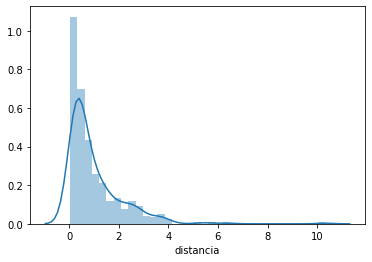

In [66]:
# a quedistancias estan?
sns.distplot(ips_estaciones_top.distancia)

In [67]:
ips_estaciones_top.distancia.quantile(q=np.linspace(0,1,11))

0.0     0.035118
0.1     0.157691
0.2     0.254547
0.3     0.321053
0.4     0.435475
0.5     0.576528
0.6     0.763201
0.7     1.116318
0.8     1.565500
0.9     2.495682
1.0    10.315739
Name: distancia, dtype: float64

## UTAM de IPS y de estaciones (WIP)
Usaremos el volumen de movilidad como proxy para el numero de trabajadores que van hacia los hospitales con esto, tambien entenderemos que porcentaje de . Primero, necesitamos el utam de los hospitales.

Tenemos que encontrar el UTAM de cada una de las estaciones e IPSs

In [81]:
ips_estaciones_top = (ips_estaciones_top.
     assign(location_ips=lambda df: df.apply(lambda r: Point(r.longitud_ips, r.latitud_ips), axis=1),
            location_estacion = lambda df: df.apply(lambda r: Point(r.longitud_estacion, r.latitud_estacion), axis=1))
)

In [83]:
ips_estaciones_top.head()

,direccion,clase_de_prestador,nit_ips,codigo_de_habilitacion,id_ips,nombre_ips,longitud_ips,latitud_ips,capacidad,numero_estacion,...,tipo_estacion,biciparqueadero_estacion,latitud_estacion,longitud_estacion,distance,distancia,cerca_rank,dist_rank,location_ips,location_estacion
18,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,61.0,9115,...,SENCILLA,NO,4.622213,-74.069588,0.110898,0.110898,1.0,1.0,POINT (-74.06983839615465 4.621247510792445),POINT (-74.06958763999999 4.62221301)
229,AC 13 N 65 -21,Instituciones - IPS,800149384,110010918632,9,CLINISANITAS DIAGNOSTICO ZONA IN,-74.116059,4.634265,179.0,5105,...,SENCILLA,SI,4.628595,-74.119050,0.712267,0.712267,1.0,1.0,POINT (-74.11605885371635 4.63426464165194),POINT (-74.11905023 4.62859531)
322,AC 145 No. 88-76,Instituciones - IPS,800149384,110010918603,630,CLINISANITAS SUBA,-74.083538,4.737664,179.0,3002,...,SENCILLA,NO,4.738202,-74.086033,0.282803,0.282803,1.0,1.0,POINT (-74.08353828993906 4.737664289640285),POINT (-74.08603261 4.73820209)
487,TRV 59 A 114 - 18 PISO 3,Instituciones - IPS,800149384,110010918614,637,LABORATORIO CLINICO SANITAS SALUD OCUPACIONAL,-74.068402,4.696660,179.0,3009,...,SENCILLA,NO,4.699181,-74.069756,0.317954,0.317954,1.0,1.0,POINT (-74.06840229005266 4.696659679755972),POINT (-74.06975627 4.69918067)
614,KR 7 32 - 12 LOCAL 304,Instituciones - IPS,800149384,110010918623,748,ODONTOSANITAS SAN MARTIN,-74.067710,4.618809,179.0,9115,...,SENCILLA,NO,4.622213,-74.069588,0.432005,0.432005,1.0,1.0,POINT (-74.06770965034106 4.618808579763447),POINT (-74.06958763999999 4.62221301)


In [102]:
ips_estaciones_top_geo = geop.GeoDataFrame(ips_estaciones_top)

In [125]:
# load utam data
utam = pd.read_pickle('../data/02_processed/utam.pkl')
utam_basic = utam[['utam', 'hogares', 'geometry', 'centroide']]

In [128]:
ips_geo_1.set_geometry('location_estacion').info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 397 entries, 18 to 59389
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   direccion                        397 non-null    object  
 1   clase_de_prestador               397 non-null    object  
 2   nit_ips                          397 non-null    object  
 3   codigo_de_habilitacion           397 non-null    int64   
 4   id_ips                           397 non-null    int64   
 5   nombre_ips                       397 non-null    object  
 6   longitud_ips                     397 non-null    float64 
 7   latitud_ips                      397 non-null    float64 
 8   capacidad                        397 non-null    float64 
 9   numero_estacion                  397 non-null    int64   
 10  nombre_estacion                  397 non-null    object  
 11  ubicacion_estacion               397 non-null    object  
 1

In [135]:
# merge utam ips
ips_geo_1 = (geop.sjoin(
    ips_estaciones_top_geo.set_geometry('location_ips'),
    utam_basic,
    how='inner',
    op='intersects'
).rename(columns={'utam':'utam_ips','hogares':'hogares_ips', 'centroide':'centroide_ips'})).drop(['index_right'], axis=1)

#merge estacion utam
ips_geo_utam = geop.sjoin(
    ips_geo_1.set_geometry('location_estacion'),
    utam_basic.set_geometry('geometry'),
    how='inner',
    op='intersects'
).rename(columns={'utam':'utam_estacion','hogares':'hogares_estacion', 'centroide':'centroide_estacion'})

C:\Users\User\Anaconda3\envs\movilidad\lib\site-packages\geopandas\tools\sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4686'})
  warn(
C:\Users\User\Anaconda3\envs\movilidad\lib\site-packages\geopandas\tools\sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4686'})
  warn(


In [136]:
ips_geo_utam

,direccion,clase_de_prestador,nit_ips,codigo_de_habilitacion,id_ips,nombre_ips,longitud_ips,latitud_ips,capacidad,numero_estacion,...,dist_rank,location_ips,location_estacion,utam_ips,hogares_ips,centroide_ips,index_right,utam_estacion,hogares_estacion,centroide_estacion
18,AC 33 # 14 37,Instituciones - IPS,830099212,110010905601,4,CENTRO DE INVESTIGACIONES ONCOLOGICAS CLINICA ...,-74.069838,4.621248,61.0,9115,...,1.0,POINT (-74.06984 4.62125),POINT (-74.06959 4.62221),UTAM91,2421.0,POINT (-74.06594 4.61988),3,UTAM101,10433.0,POINT (-74.07392 4.62796)
614,KR 7 32 - 12 LOCAL 304,Instituciones - IPS,800149384,110010918623,748,ODONTOSANITAS SAN MARTIN,-74.067710,4.618809,179.0,9115,...,1.0,POINT (-74.06771 4.61881),POINT (-74.06959 4.62221),UTAM91,2421.0,POINT (-74.06594 4.61988),3,UTAM101,10433.0,POINT (-74.07392 4.62796)
24305,CL 36 # 7 47 PI 3,Instituciones - IPS,860007336,110010817122,958,CONSULTORIO DE EMPRESA BANCO DE BOGOTA,-74.067370,4.623381,48.0,9115,...,1.0,POINT (-74.06737 4.62338),POINT (-74.06959 4.62221),UTAM91,2421.0,POINT (-74.06594 4.61988),3,UTAM101,10433.0,POINT (-74.07392 4.62796)
24603,KR 13 A 35 38 Piso 5 Edificio torre B-35,Instituciones - IPS,860007336,110010817147,2128,CONSULTORIO DE EMPRESA BANCO DE BOGOTA 2,-74.068254,4.623526,48.0,9115,...,1.0,POINT (-74.06825 4.62353),POINT (-74.06959 4.62221),UTAM91,2421.0,POINT (-74.06594 4.61988),3,UTAM101,10433.0,POINT (-74.07392 4.62796)
39056,CARRERA 5 NUMERO 33 A-45,Instituciones - IPS,900959051,110013028915,2845,UNIDAD DE SERVICIOS DE SALUD PERSEVERANCIA,-74.065509,4.619988,139.0,9115,...,1.0,POINT (-74.06551 4.61999),POINT (-74.06959 4.62221),UTAM91,2421.0,POINT (-74.06594 4.61988),3,UTAM101,10433.0,POINT (-74.07392 4.62796)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29832,CL 66 A # 52 25,Instituciones - IPS,900210981,110011864202,1198,HOSPITAL UNIVERSITARIO BARRIOS UNIDOS-MEDERI,-74.080112,4.663685,452.0,7103,...,1.0,POINT (-74.08011 4.66368),POINT (-74.07399 4.66690),UTAM22,28384.0,POINT (-74.07930 4.67184),82,UTAM98,23701.0,POINT (-74.06819 4.66244)
31173,CARRERA 54 # 65-85,Instituciones - IPS,860013874,110010825806,2318,SEDE PROPACE,-74.080995,4.664163,5.0,7103,...,1.0,POINT (-74.08099 4.66416),POINT (-74.07399 4.66690),UTAM22,28384.0,POINT (-74.07930 4.67184),82,UTAM98,23701.0,POINT (-74.06819 4.66244)
58291,KR 52 # 67 A 71,Instituciones - IPS,900098476,110011613301,903,HOSPITAL INFANTIL UNIVERSITARIO DE SAN JOSE,-74.078972,4.665141,86.0,7103,...,1.0,POINT (-74.07897 4.66514),POINT (-74.07399 4.66690),UTAM22,28384.0,POINT (-74.07930 4.67184),82,UTAM98,23701.0,POINT (-74.06819 4.66244)
42193,CL 57 SUR No. 67 - 27,Instituciones - IPS,900958564,110013029411,2897,UNIDAD DE SERVICIOS DE SALUD ISLA DEL SOL,-74.157403,4.595513,108.0,7002,...,1.0,POINT (-74.15740 4.59551),POINT (-74.15726 4.59624),UTAM65,17551.0,POINT (-74.15279 4.58318),51,UTAM65,17551.0,POINT (-74.15279 4.58318)


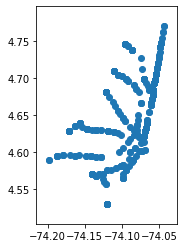

In [116]:
ips_geo_1.set_geometry('location_estacion').plot()